In [1]:
import cv2
import scipy
import numpy as np
import matplotlib.pyplot as plt

$\textbf{Helper Functions}$

Scale Space Creation

In [25]:
def downsample(img, factor):
    """
    in:
        -img: greyscale img matrix
        -factor: factor by which we are downsampling
    out:
        -img downsampled by factor
    """
    return np.array(img[::factor, ::factor])

#does not add extra scales to compensate for dog and extrema detection
def create_octave(img, kernel_size, sigma, k, s_count):
    """
    in:
        -img: greyscale img matrix
        -kernel_size, sigma: Gaussian dims
        -k: sigma coefficient
        -s_count: how many scales in octave
    out:
        -octave: np.ndarray of blurred imgs
    """

    assert kernel_size % 2 == 1, "kernel has no center"
    assert s_count > 0, "s_count must be nonzero positive int"
    
    m, n = img.shape 
    octave = np.zeros((s_count, m, n))

    for scale_it in range(s_count):
        octave[scale_it] = cv2.GaussianBlur(img, (kernel_size, kernel_size), sigma * k**scale_it)
    return octave
    
def create_dog_octave(octave):
    """
    in:
        -octave: output from create_octave()
    out:
        -dog_octave: np.ndarray of DoG imgs that is 1 shorter than octave
    """

    s, m, n = octave.shape 
    assert s > 1, "not enough scales to create DoG"
    
    dog_octave = np.zeros((s - 1, m, n))
    
    for dog_it in range(len(dog_octave)):
        dog_octave[dog_it] = octave[dog_it] - octave[dog_it + 1]

    return dog_octave
    
def create_scale_space(img, kernel_size, sigma, k, s_count, o_count):
    """
    in:
        -img: greyscale img matrix
        -kernel_size, sigma: Gaussian dims
        -k: sigma coefficient
        -s_count: how many scales in octave
        -o_count: how many octaves in scale space
    out:
        -scale_space: list of octaves of dogs
        -gaussian_space: list of octaves of gaussian blurred images
    """
    
    #initial blur removing high freq
    scaled_img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0.5)
    
    scale_space = []
    gaussian_space = []
    for octave_it in range(o_count):
        octave = create_octave(scaled_img, kernel_size, sigma, k, s_count)
        dog_octave = create_dog_octave(octave)

        gaussian_space.append(octave)
        scale_space.append(dog_octave)
        scaled_img = downsample(scaled_img, 2)
    return scale_space, gaussian_space



Descriptor Creation

In [83]:
def find_keypoints(scale_space):
    """
    in:
        -scale_space: output of create_scale_space()
    out:
        -keypoints: list of coords of keypoints (octave, scale, row, col)
    """
    DESCRIPTOR_WINDOW_SIZE = 16
    EXTREMA_FILTER_SIZE = 10
    FIRST_SCALE_I = 0
    LAST_SCALE_I = 4
    
    #local extrema
    extrema = [] 
    for octave in scale_space:
        #local extrema
        maxes = octave == scipy.ndimage.maximum_filter(octave, EXTREMA_FILTER_SIZE)
        mins = octave == scipy.ndimage.minimum_filter(octave, EXTREMA_FILTER_SIZE)
        octave_extrema = np.logical_or(maxes, mins)
        octave_extrema = np.logical_and(octave_extrema, np.abs(octave) >= 0.04)

        dx = scipy.ndimage.sobel(octave, axis=1)
        dy = scipy.ndimage.sobel(octave, axis=0)
        dxx = scipy.ndimage.sobel(dx, axis=1)
        dxy = scipy.ndimage.sobel(dx, axis=0)
        dyy = scipy.ndimage.sobel(dy, axis=0)

        #Hessian ratio to remove edge responses
        Hessian_det = dxx*dyy - dxy**2
        
        zero_det_filter = Hessian_det == 0#dealing with zero divides
        Hessian_det[zero_det_filter] = 1
        Hessian_tr = dxx + dyy
        R = 10
        Hessian_filter = (Hessian_tr**2 / Hessian_det) <= ( (R + 1)**2 / R )
        octave_extrema = np.logical_and(octave_extrema, Hessian_filter) #removing edge responses
        octave_extrema = np.logical_and(octave_extrema, ~zero_det_filter) #removing kp with zero det hessians

        #removing kp too close to img edges
        s, m, n = octave.shape
        edge_filter = np.zeros((s, m, n))
        edge_filter[:, DESCRIPTOR_WINDOW_SIZE:m-DESCRIPTOR_WINDOW_SIZE, DESCRIPTOR_WINDOW_SIZE:n-DESCRIPTOR_WINDOW_SIZE] = 1
        octave_extrema = np.logical_and(octave_extrema, edge_filter)

        #removing kp on first or last scale
        octave_extrema[FIRST_SCALE_I, :, :] = 0
        octave_extrema[LAST_SCALE_I, :, :] = 0

        extrema.append(octave_extrema)

    keypoints = []
    for octave_extrema in extrema:
        keypoints.append(np.argwhere(octave_extrema))

    return keypoints

def compute_gradients_and_orientations(gaussian_space):
    """
    in:
        -gaussian_space: octaves of scales of gaussian blurred imgs
    out:
        -gradients: estimated gradient values of each scale in each octave (same shape as gaussian space)
        -gradient_orientations: estimated orientation values of each gradient in each scale in each octave (same shape as gaussian space)
    """

    gradients = []
    gradient_orientations = []
    
    for octave in gaussian_space:
        s, m, n = octave.shape
        padded_octave = np.pad(octave, ((0, 0), (1, 1), (1, 1)), mode="constant")
            #right patch - left patch
        dx = padded_octave[:, 1:m+1, 2:n+2] - padded_octave[:, 1:m+1, :n]
            #top patch - bottom patch
        dy = padded_octave[:, :m, 1:n+1] - padded_octave[:, 2:m+2, 1:n+1]

        gradients.append( np.hypot(dx**2 + dy**2) )
        gradient_orientations.append( (np.arctan2(dy, dx) + np.pi) % (2*np.pi) ) #bounding to [0, 2pi)
    return gradients, gradient_orientations
    
#determine dominant orientations of each keypoint using histogram, weighting stuff by both gaussian window and gradient I think
def assign_orientations(scale_space, gradients, gradient_orientations, keypoints, base_sigma, k):
    """
    in:
        -scale_space: output of create_scale_space()
        -gradients, orientations: output of compute_gradients_and_orientations()
        -keypoints: output of find_keypoints()
        -base_sigma, k: same vals used to create scale space
    out:
        -altered_keypoints: list of keypoints including ones created from additional dominant orientations
        -dominant_orientations: list of dominant orientations (corresponding kp and ori have same indices)
        *note: The scale of the img with lower sigma used to create each dog will be the assigned scale of that dog (used to determine sample radius for determining orientation)
    """
    altered_keypoints = []
    dominant_orientations = []
    for octave_it, octave in enumerate(keypoints):
        for keypoint in octave:
            keypoint_sigma = base_sigma * 2**octave_it * k**keypoint[0]
            weight_sigma = 1.5 * keypoint_sigma
            radius = 3 * keypoint_sigma #orisigma val?
            histogram = np.zeros(36)
            

    
    pass
def compute_descriptors(scale_space, keypoints, orientations):
    """
    """
    pass

SyntaxError: invalid syntax (655151496.py, line 94)

In [75]:
img1 = cv2.imread("imgA.png")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

img2 = cv2.imread("imgB.png")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

BASE_SIGMA = 1.6
KERNEL_SIZE = 15
K = 1.26
S_COUNT = 3 + 3 #3 extra because we want 3 useful ones. dog takes away one and extrema does not consider 2
O_COUNT = 3


In [78]:
scale_space, gaussian_space = create_scale_space(img1, KERNEL_SIZE, BASE_SIGMA, K, S_COUNT, O_COUNT)
keypoints = find_keypoints(scale_space)
gradients, gradient_orientations = compute_gradients_and_orientations(gaussian_space)
assign_orientations(scale_space, gradients, gradient_orientations, keypoints, BASE_SIGMA, K)


In [67]:
print(keypoints)

[array([[  1,  16,  48],
       [  1,  16,  53],
       [  1,  16,  55],
       ...,
       [  3, 623, 641],
       [  3, 623, 665],
       [  3, 623, 731]]), array([[  1,  16,  20],
       [  1,  16,  27],
       [  1,  16, 324],
       ...,
       [  3, 303,  17],
       [  3, 303, 252],
       [  3, 303, 272]]), array([[  1,  16, 113],
       [  1,  18,  30],
       [  1,  18, 176],
       ...,
       [  3, 124, 179],
       [  3, 124, 181],
       [  3, 137,  44]])]


In [6]:
# fig, ax = plt.subplots(o_count, s_count-1, figsize=(20, 20))
# for o in range(o_count):
#     for s in range(s_count-1):
#         ax[o, s].imshow(scale_space[o][s], cmap="gray")

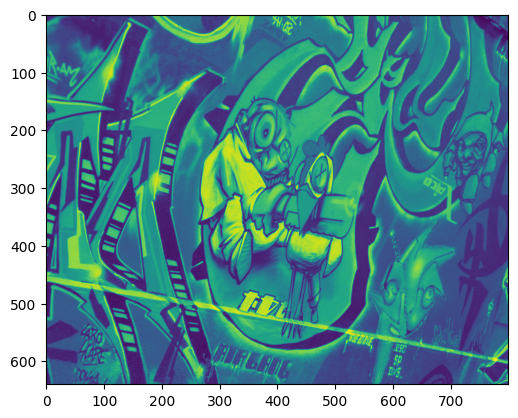

In [7]:
plt.imshow(img1)

$\textbf{testing np.pad()}$

In [44]:
#testing np.pad

test = np.zeros((3, 2, 2))
                    #axis 1, 2, 3 padding before and after 
test = np.pad(test, ((0, 0), (1, 1), (1, 1)), mode="constant")
print(test)

[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


In [82]:
test = []
test.append(np.zeros(5))
def alter(array):
    array[0] = np.vstack([array[0], np.full((5), 1)])

print(test)
alter(test)
print(test)
    

[array([0., 0., 0., 0., 0.])]
[array([[0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.]])]
